In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from model import BuildingSimulation as bs, BuildingGraph as bg
from model.utils import *
import matplotlib.colors as mcolors
from model.WallSimulation import convectionDOE2
from runMyBuildingMC import cleanMaterial, getConstructions, setConstructionType
from model.WallSimulation import processMaterials


## DOE-2 Convection

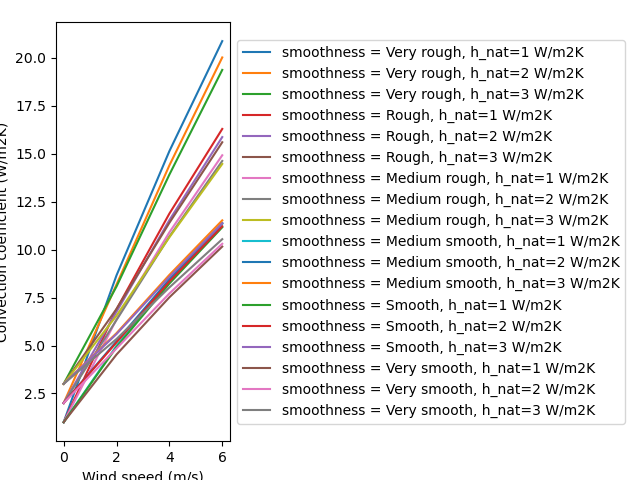

In [2]:
R_f = pd.Series({
    "Very rough": 2.17,
    "Rough": 1.67,
    "Medium rough": 1.52,
    "Medium smooth": 1.13,
    "Smooth": 1.11,
    "Very smooth": 1.00,
})

V = [0, 2, 4, 6]
h_nat = [1, 2, 3]
plt.figure()
for smoothness, r_f in R_f.items():
    for h in h_nat:
        plt.plot(V, convectionDOE2(h, V, r_f), label=f"smoothness = {smoothness}, h_nat={h} W/m2K")
#specify legend outside of plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#make plot tight
plt.tight_layout()
xlabel = plt.xlabel("Wind speed (m/s)")
ylabel = plt.ylabel("Convection coefficient (W/m2K)")


# Checking Constructions

## Default (bad)

In [3]:
for materialType in ["Light", "Medium", "Heavy"]:
    materials = getConstructions(materialType)
    wallMaterial = processMaterials(materials["wall"], 9)
    partitionMaterial = processMaterials(materials["partition"], 9)
    roofMaterial = processMaterials(materials["roof"], 9)
    floorMaterial = processMaterials(materials["floor"], 9)

    # display(f"{materialType} materials")
    # display(wallMaterial)
    # display(f"total wall R-value in ft²-hr-°F/Btu: {wallMaterial['Thermal_Resistance'].sum() * 5.678}, U-value in W/m²K: {1 / (wallMaterial['Thermal_Resistance'].sum() * 5.678)}")
    # display(partitionMaterial)
    # display(f"total partition R-value in ft²-hr-°F/Btu: {partitionMaterial['Thermal_Resistance'].sum() * 5.678}, U-value in W/m²K: {1 / (partitionMaterial['Thermal_Resistance'].sum() * 5.678)}")
    # display(roofMaterial)
    # display(f"total roof R-value in ft²-hr-°F/Btu: {roofMaterial['Thermal_Resistance'].sum() * 5.678}, U-value in W/m²K: {1 / (roofMaterial['Thermal_Resistance'].sum() * 5.678)}")
    # display(floorMaterial)
    # display(f"total floor R-value (no soil) in ft²-hr-°F/Btu: {floorMaterial['Thermal_Resistance'].iloc[:-1].sum() * 5.678}, U-value in W/m²K: {1 / (floorMaterial['Thermal_Resistance'].iloc[:-1].sum() * 5.678)}")

## My Constructions (good)

In [4]:
materials = getConstructions("My", constructionFile = "energyPlus/My_Constructions.csv")
wallMaterial = materials["wall"]
partitionMaterial = materials["partition"]
roofMaterial = materials["roof"]
floorMaterial = materials["floor"]

display(wallMaterial)
display(f"total wall R-value in ft²-hr-°F/Btu: {wallMaterial['Thermal_Resistance'].sum() * 5.678}, U-value in W/m²K: {1 / (wallMaterial['Thermal_Resistance'].sum() * 5.678)}")
display(partitionMaterial)
display(f"total partition R-value in ft²-hr-°F/Btu: {partitionMaterial['Thermal_Resistance'].sum() * 5.678}, U-value in W/m²K: {1 / (partitionMaterial['Thermal_Resistance'].sum() * 5.678)}")
display(roofMaterial)
display(f"total roof R-value in ft²-hr-°F/Btu: {roofMaterial['Thermal_Resistance'].sum() * 5.678}, U-value in W/m²K: {1 / (roofMaterial['Thermal_Resistance'].sum() * 5.678)}")
display(floorMaterial)
display(f"total floor R-value (no soil) in ft²-hr-°F/Btu: {floorMaterial['Thermal_Resistance'].iloc[:-1].sum() * 5.678}, U-value in W/m²K: {1 / (floorMaterial['Thermal_Resistance'].iloc[:-1].sum() * 5.678)}")

,key,Roughness,Thickness,Conductivity,Density,Specific_Heat,Thermal_Resistance
G01 16mm gypsum board,Material,MediumSmooth,0.0159,0.16,800.0,1090.0,NaN
F04 Wall air space resistance,Material:AirGap,NaN,NaN,NaN,NaN,NaN,0.15
I02 50mm insulation board,Material,MediumRough,0.0508,0.03,43.0,1210.0,NaN
Plywood (Douglas Fir) - 12.7mm,Material,Smooth,0.0127,0.12,540.0,1210.0,NaN


'total wall R-value in ft²-hr-°F/Btu: 0.8517, U-value in W/m²K: 1.1741223435481978'

,key,Roughness,Thickness,Conductivity,Density,Specific_Heat,Thermal_Resistance
G01 16mm gypsum board,Material,MediumSmooth,0.0159,0.16,800.0,1090.0,NaN
F04 Wall air space resistance,Material:AirGap,NaN,NaN,NaN,NaN,NaN,0.15
G01 16mm gypsum board,Material,MediumSmooth,0.0159,0.16,800.0,1090.0,NaN


'total partition R-value in ft²-hr-°F/Btu: 0.8517, U-value in W/m²K: 1.1741223435481978'

,key,Roughness,Thickness,Conductivity,Density,Specific_Heat,Thermal_Resistance
G01 16mm gypsum board,Material,MediumSmooth,0.0159,0.16,800.0,1090.0,NaN
I05 154mm batt insulation,Material,VeryRough,0.1544,0.05,19.0,960.0,NaN
F05 Ceiling air space resistance,Material:AirGap,NaN,NaN,NaN,NaN,NaN,0.18
Plywood (Douglas Fir) - 12.7mm,Material,Smooth,0.0127,0.12,540.0,1210.0,NaN


'total roof R-value in ft²-hr-°F/Btu: 1.02204, U-value in W/m²K: 0.9784352862901647'

,key,Roughness,Thickness,Conductivity,Density,Specific_Heat,Thermal_Resistance
Plywood (Douglas Fir) - 12.7mm,Material,Smooth,0.0127,0.12,540.0,1210.0,NaN
I05 154mm batt insulation,Material,VeryRough,0.1544,0.05,19.0,960.0,NaN
F05 Ceiling air space resistance,Material:AirGap,NaN,NaN,NaN,NaN,NaN,0.18
M15 200mm heavyweight concrete,Material,MediumRough,0.2032,1.95,2240.0,900.0,NaN
Soil,Material,NaN,0.5000,1.50,2800.0,850.0,NaN


'total floor R-value (no soil) in ft²-hr-°F/Btu: 1.02204, U-value in W/m²K: 0.9784352862901647'

In [5]:
for materialType in ["Light", "Medium", "Heavy"]:
    adjustedMaterials = setConstructionType(materials, materialType)
    wallMaterial = adjustedMaterials["wall"]
    partitionMaterial = adjustedMaterials["partition"]
    roofMaterial = adjustedMaterials["roof"]
    floorMaterial = adjustedMaterials["floor"]
    display(wallMaterial)
    display(f"total wall R-value in ft²-hr-°F/Btu: {wallMaterial['Thermal_Resistance'].sum() * 5.678}, U-value in W/m²K: {1 / (wallMaterial['Thermal_Resistance'].sum() * 5.678)}")
    display(partitionMaterial)
    display(f"total partition R-value in ft²-hr-°F/Btu: {partitionMaterial['Thermal_Resistance'].sum() * 5.678}, U-value in W/m²K: {1 / (partitionMaterial['Thermal_Resistance'].sum() * 5.678)}")
    display(roofMaterial)
    display(f"total roof R-value in ft²-hr-°F/Btu: {roofMaterial['Thermal_Resistance'].sum() * 5.678}, U-value in W/m²K: {1 / (roofMaterial['Thermal_Resistance'].sum() * 5.678)}")
    display(floorMaterial)
    display(f"total floor R-value (no soil) in ft²-hr-°F/Btu: {floorMaterial['Thermal_Resistance'].iloc[:-1].sum() * 5.678}, U-value in W/m²K: {1 / (floorMaterial['Thermal_Resistance'].iloc[:-1].sum() * 5.678)}")



,key,Roughness,Thickness,Conductivity,Density,Specific_Heat,Thermal_Resistance,depth
G01 16mm gypsum board,Material,MediumSmooth,0.015900,0.16,800.0,1090.0,0.099375,0.015900
F04 Wall air space resistance,Material:AirGap,NaN,NaN,NaN,NaN,NaN,0.150000,NaN
I02 50mm insulation board,Material,MediumRough,0.031612,0.03,43.0,1210.0,1.053738,0.047512
Plywood (Douglas Fir) - 12.7mm,Material,Smooth,0.012700,0.12,540.0,1210.0,0.105833,0.060212


'total wall R-value in ft²-hr-°F/Btu: 8.0, U-value in W/m²K: 0.125'

,key,Roughness,Thickness,Conductivity,Density,Specific_Heat,Thermal_Resistance,depth
G01 16mm gypsum board,Material,MediumSmooth,0.0159,0.16,800.0,1090.0,NaN,0.0159
F04 Wall air space resistance,Material:AirGap,NaN,NaN,NaN,NaN,NaN,0.15,NaN
G01 16mm gypsum board,Material,MediumSmooth,0.0159,0.16,800.0,1090.0,NaN,0.0318


'total partition R-value in ft²-hr-°F/Btu: 0.8517, U-value in W/m²K: 1.1741223435481978'

,key,Roughness,Thickness,Conductivity,Density,Specific_Heat,Thermal_Resistance,depth
G01 16mm gypsum board,Material,MediumSmooth,0.015900,0.16,800.0,1090.0,0.099375,0.015900
I05 154mm batt insulation,Material,VeryRough,0.156858,0.05,19.0,960.0,3.137159,0.172758
F05 Ceiling air space resistance,Material:AirGap,NaN,NaN,NaN,NaN,NaN,0.180000,NaN
Plywood (Douglas Fir) - 12.7mm,Material,Smooth,0.012700,0.12,540.0,1210.0,0.105833,0.185458


'total roof R-value in ft²-hr-°F/Btu: 20.000000000000004, U-value in W/m²K: 0.04999999999999999'

,key,Roughness,Thickness,Conductivity,Density,Specific_Heat,Thermal_Resistance,depth
Plywood (Douglas Fir) - 12.7mm,Material,Smooth,0.012700,0.12,540.0,1210.0,0.105833,0.012700
I05 154mm batt insulation,Material,VeryRough,0.094975,0.05,19.0,960.0,1.899500,0.107675
F05 Ceiling air space resistance,Material:AirGap,NaN,NaN,NaN,NaN,NaN,0.180000,NaN
M15 200mm heavyweight concrete,Material,MediumRough,0.203200,1.95,2240.0,900.0,0.104205,0.310875
Soil,Material,NaN,0.500000,1.50,2800.0,850.0,0.333333,0.810875


'total floor R-value (no soil) in ft²-hr-°F/Btu: 13.0, U-value in W/m²K: 0.07692307692307693'

,key,Roughness,Thickness,Conductivity,Density,Specific_Heat,Thermal_Resistance,depth
G01 16mm gypsum board,Material,MediumSmooth,0.01590,0.16,800.0,1090.0,0.099375,0.01590
F04 Wall air space resistance,Material:AirGap,NaN,NaN,NaN,NaN,NaN,0.150000,NaN
I02 50mm insulation board,Material,MediumRough,0.05803,0.03,43.0,1210.0,1.934330,0.07393
Plywood (Douglas Fir) - 12.7mm,Material,Smooth,0.01270,0.12,540.0,1210.0,0.105833,0.08663


'total wall R-value in ft²-hr-°F/Btu: 13.0, U-value in W/m²K: 0.07692307692307693'

,key,Roughness,Thickness,Conductivity,Density,Specific_Heat,Thermal_Resistance,depth
G01 16mm gypsum board,Material,MediumSmooth,0.0159,0.16,800.0,1090.0,NaN,0.0159
F04 Wall air space resistance,Material:AirGap,NaN,NaN,NaN,NaN,NaN,0.15,NaN
G01 16mm gypsum board,Material,MediumSmooth,0.0159,0.16,800.0,1090.0,NaN,0.0318


'total partition R-value in ft²-hr-°F/Btu: 0.8517, U-value in W/m²K: 1.1741223435481978'

,key,Roughness,Thickness,Conductivity,Density,Specific_Heat,Thermal_Resistance,depth
G01 16mm gypsum board,Material,MediumSmooth,0.015900,0.16,800.0,1090.0,0.099375,0.015900
I05 154mm batt insulation,Material,VeryRough,0.209693,0.05,19.0,960.0,4.193869,0.225593
F05 Ceiling air space resistance,Material:AirGap,NaN,NaN,NaN,NaN,NaN,0.180000,NaN
Plywood (Douglas Fir) - 12.7mm,Material,Smooth,0.012700,0.12,540.0,1210.0,0.105833,0.238293


'total roof R-value in ft²-hr-°F/Btu: 25.999999999999996, U-value in W/m²K: 0.038461538461538464'

,key,Roughness,Thickness,Conductivity,Density,Specific_Heat,Thermal_Resistance,depth
Plywood (Douglas Fir) - 12.7mm,Material,Smooth,0.012700,0.12,540.0,1210.0,0.105833,0.012700
I05 154mm batt insulation,Material,VeryRough,0.156616,0.05,19.0,960.0,3.132329,0.169316
F05 Ceiling air space resistance,Material:AirGap,NaN,NaN,NaN,NaN,NaN,0.180000,NaN
M15 200mm heavyweight concrete,Material,MediumRough,0.203200,1.95,2240.0,900.0,0.104205,0.372516
Soil,Material,NaN,0.500000,1.50,2800.0,850.0,0.333333,0.872516


'total floor R-value (no soil) in ft²-hr-°F/Btu: 20.0, U-value in W/m²K: 0.05'

,key,Roughness,Thickness,Conductivity,Density,Specific_Heat,Thermal_Resistance,depth
G01 16mm gypsum board,Material,MediumSmooth,0.015900,0.16,800.0,1090.0,0.099375,0.015900
F04 Wall air space resistance,Material:AirGap,NaN,NaN,NaN,NaN,NaN,0.150000,NaN
I02 50mm insulation board,Material,MediumRough,0.095015,0.03,43.0,1210.0,3.167159,0.110915
Plywood (Douglas Fir) - 12.7mm,Material,Smooth,0.012700,0.12,540.0,1210.0,0.105833,0.123615


'total wall R-value in ft²-hr-°F/Btu: 20.0, U-value in W/m²K: 0.05'

,key,Roughness,Thickness,Conductivity,Density,Specific_Heat,Thermal_Resistance,depth
G01 16mm gypsum board,Material,MediumSmooth,0.0159,0.16,800.0,1090.0,NaN,0.0159
F04 Wall air space resistance,Material:AirGap,NaN,NaN,NaN,NaN,NaN,0.15,NaN
G01 16mm gypsum board,Material,MediumSmooth,0.0159,0.16,800.0,1090.0,NaN,0.0318


'total partition R-value in ft²-hr-°F/Btu: 0.8517, U-value in W/m²K: 1.1741223435481978'

,key,Roughness,Thickness,Conductivity,Density,Specific_Heat,Thermal_Resistance,depth
G01 16mm gypsum board,Material,MediumSmooth,0.015900,0.16,800.0,1090.0,0.099375,0.015900
I05 154mm batt insulation,Material,VeryRough,0.315364,0.05,19.0,960.0,6.307289,0.331264
F05 Ceiling air space resistance,Material:AirGap,NaN,NaN,NaN,NaN,NaN,0.180000,NaN
Plywood (Douglas Fir) - 12.7mm,Material,Smooth,0.012700,0.12,540.0,1210.0,0.105833,0.343964


'total roof R-value in ft²-hr-°F/Btu: 38.0, U-value in W/m²K: 0.02631578947368421'

,key,Roughness,Thickness,Conductivity,Density,Specific_Heat,Thermal_Resistance,depth
Plywood (Douglas Fir) - 12.7mm,Material,Smooth,0.012700,0.12,540.0,1210.0,0.105833,0.012700
I05 154mm batt insulation,Material,VeryRough,0.227064,0.05,19.0,960.0,4.541275,0.239764
F05 Ceiling air space resistance,Material:AirGap,NaN,NaN,NaN,NaN,NaN,0.180000,NaN
M15 200mm heavyweight concrete,Material,MediumRough,0.203200,1.95,2240.0,900.0,0.104205,0.442964
Soil,Material,NaN,0.500000,1.50,2800.0,850.0,0.333333,0.942964


'total floor R-value (no soil) in ft²-hr-°F/Btu: 27.999999999999996, U-value in W/m²K: 0.03571428571428572'

In [6]:
processMaterials(floorMaterial, 9)

,key,Roughness,Thickness,Conductivity,Density,Specific_Heat,Thermal_Resistance,depth,n
index,,,,,,,,,
Plywood (Douglas Fir) - 12.7mm,Material,Smooth,0.094296,0.016162,540.0,162.964904,5.834519,0.094296,1
I05 154mm batt insulation,Material,VeryRough,0.188593,0.060199,19.0,1155.830295,3.132796,0.282889,2
F05 Ceiling air space resistance,Material:AirGap,NaN,0.094296,0.523869,12.0,1005.000000,0.180000,0.377186,1
M15 200mm heavyweight concrete,Material,MediumRough,0.188593,2.101035,2240.0,969.708519,0.089762,0.565778,2
Soil,Material,NaN,0.471482,1.590729,2800.0,901.413212,0.296394,1.037260,5


## Multi Walls

In [7]:
# constructions  = pd.read_csv("energyPlus/ASHRAE_2005_HOF_Constructions.csv", index_col="Name")
# materials = pd.read_csv("energyPlus/ASHRAE_2005_HOF_Materials.csv", index_col="Name")

In [8]:
sim_kwargs = {
    "delt": 10,
    "simLength": 96 * 60 * 60,
    "Tout" : 288.15,
    "radG": 400,
    "Tfloor": None,
}
wall_kwargs = {"X": 9, "Y": 10, "material_df": wallMaterial, "h": WallSides(4, 4), "alpha" : 0.7}

room_kwargs = {
    "T0": 293.15,
    "V" : 2880, #volume of air
    "Eint" : 250 #internal heat generation
}
vent_kwargs = {
    'H': 1,
    'W' : 1,
    "ventType": "HWP1",
    "alphas": None,
    "As": None,
    "Ls": None
}

connectivityMatrix = np.array([
    [3],
])

roomList = [
    ("R", {}), #room
    ]


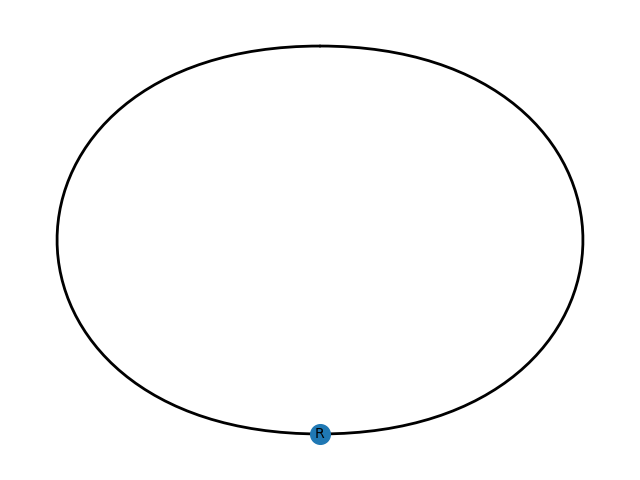

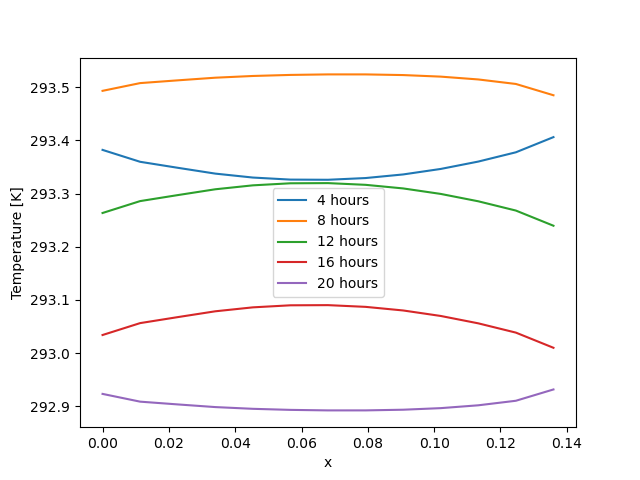

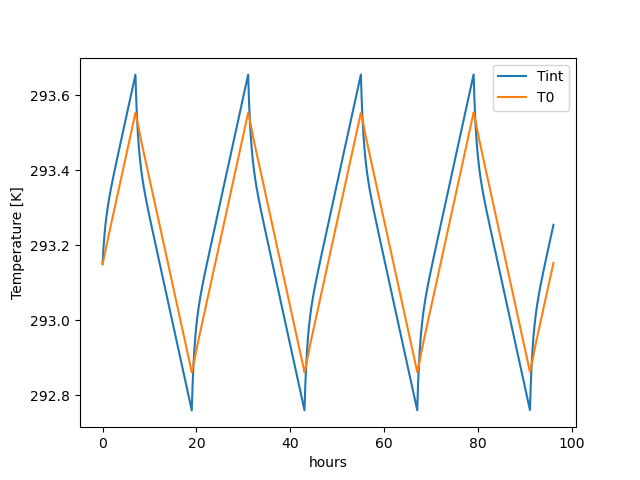

In [11]:
bG = bg.BuildingGraph(connectivityMatrix, roomList)
bG.updateEdges({"wall_kwargs" :wall_kwargs})
bG.updateNodes({
    "room_kwargs": room_kwargs,
    "vent_kwargs": vent_kwargs,
        "rad_kwargs": {"solveType": None},
    })
bG.draw()

build_sim = bs.BuildingSimulation(**sim_kwargs)
build_sim.initialize(bG)

build_sim.run()

Tints = build_sim.bG.G.nodes['R']['Tints']
T_profs = build_sim.bG.G.edges['R', 'R']['T_profs']
wall = build_sim.bG.G.edges['R', 'R']['wall']
h_profs = [4, 8, 12, 16, 20]
h_profs = [h + 48 for h in h_profs]
# h_profs = [0, *h_profs]

# Plotting
plt.figure()
plt.plot(build_sim.hours, Tints, label='Tint')
plt.plot(build_sim.hours, T_profs[0, :], label='T0')
plt.legend()
plt.xlabel('hours')
plt.ylabel('Temperature [K]')

plt.figure()
for h in h_profs:
    i = int(h * 60 * 60 / build_sim.delt)
    plt.plot(wall.x, T_profs[:, i], label=f'{h % 24} hours')

plt.legend()
plt.xlabel('x')
plt.ylabel('Temperature [K]')
plt.show()